# Kohonen Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def gauss_nhood(x, t=None):
    if t is None:
        t = 1
    return np.exp(-(x * t) ** 2)

def mexican_hat_nhood(x, t=None):
    if t is None:
        t = 1
    return (2 - 4*(x*t) ** 2) * np.exp(-(x * t) ** 2)

def exp_decay(t, lambda_max):
    """ t: current interation """
    return np.exp(-t / lambda_max)

def euclidean_distance(a, b):
    return np.linalg.norm(np.subtract(a, b), ord=2, axis=-1)

def standardize_data(X):
    """
    returns:
    X_new - standardized X
    a tuple (mean, std) - normal distribution parameters from X for destandarizing
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

In [100]:
class KOH:

    def __init__(self, input_dim, shape, distance_metric=euclidean_distance, decay_function=exp_decay, neighborhood_function=gauss_nhood):
        """
        input_dim: number of input vectors, neuron dim
        shape: tuple (N, M)
        """
        assert len(shape) == 2
        self.input_dim = input_dim
        self.shape = shape
        self.weights = self.random_init()
        self.distance_metric = distance_metric
        self.decay_function = decay_function
        self.neighborhood_function = neighborhood_function
        self.data = None
    
    def random_init(self):
        return np.random.standard_normal(
            size=(self.shape[0], self.shape[1], self.input_dim)
        )

    def nhood_weight(self, n1, n2, t=None, r=None):
        """ calculates neighborhood distance """
        if r is None:
            r = 1
        return self.neighborhood_function(self.distance_metric(n1, n2) * r, t)

    def find_bmu(self, x):
        """ finds best matching unit """
        index = np.argmin(self.distance_metric(self.weights, x))
        return np.unravel_index(index, self.shape)
    
    def get_weights(self, indices):
        """ get weights from indices """
        return self.weights[indices[0]][indices[1]]
                    
    def update_weights(self, x, bmu, t, lambda_max, r, use_nhood_decay=False):
        """ updates weights """
        time = None
        if use_nhood_decay:
            time = t
            
        nhood_weights = self.nhood_weight(bmu, self.weights, time, r)
        nhood_weights_tensor = np.stack((nhood_weights, ) * self.input_dim, axis=2)
        
        self.weights = self.weights + exp_decay(t, lambda_max) * nhood_weights_tensor * (x - self.weights)

    def predict(self, data):
        predictions = []
        for x in data:
            predictions.append(np.argmin(self.distance_metric(self.weights, x)))
        return np.array(predictions)
    
    def train(self, data, lambda_max, r=None, use_nhood_decay=False):
        """ 
        lambda_max: number of iterations
        """
        self.data = data
        shuffled_data = np.copy(data)
        np.random.shuffle(shuffled_data)
        
        for t in range(1, lambda_max+1):
            for x in shuffled_data:
                bmu_indices = self.find_bmu(x)
                bmu = self.get_weights(bmu_indices)
                self.update_weights(x, bmu, t, lambda_max, r, use_nhood_decay)

    def plot_clusters(self, labels, type='hex'):
        """ labels: pandas series """
        if type == 'hex':
            weights_res = self.weights.reshape(-1, 2)
            sns.scatterplot(x=self.data[:,0], y=self.data[:,1], hue=labels.to_numpy())
            sns.scatterplot(x=weights_res[:,0], y=weights_res[:,1])
            plt.show()
        elif type == 'cube':
            weights_res = self.weights.reshape(-1, 3)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(self.data[:,0], self.data[:,1], self.data[:,2], c=labels.to_numpy(), marker='o', alpha=0.2)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.scatter(weights_res[:,0], weights_res[:,1], weights_res[:,2], c='k', alpha=1)
            plt.show()

## Data

In [4]:
hexagon = pd.read_csv("dane/hexagon.csv")
cube = pd.read_csv("dane/cube.csv")

In [5]:
hex_train = hexagon[['x', 'y']].to_numpy()
cube_train = cube[['x', 'y', 'z']].to_numpy()

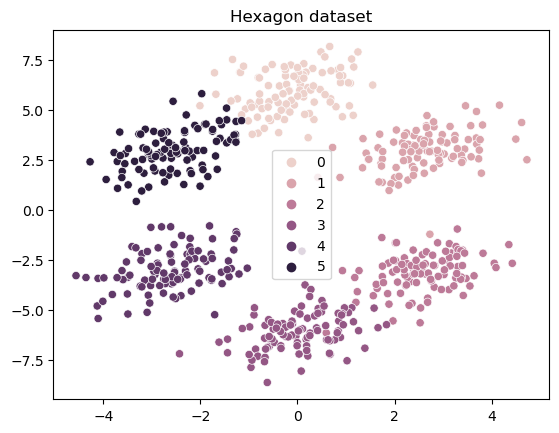

In [13]:
sns.scatterplot(x=hex_train[:,0], y=hex_train[:,1], hue=hexagon['c'].to_numpy()).set_title('Hexagon dataset')
plt.show()

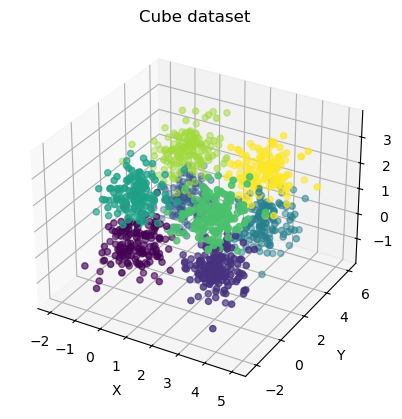

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_train[:,0], cube_train[:,1], cube_train[:,2], c=cube['c'].to_numpy(), marker='o')  # Color is blue, marker is circle
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Cube dataset')
plt.show()

## Tests

In [16]:
# K = M x N
# C - number of classes

In [7]:
from sklearn.metrics import v_measure_score

### Hexagon dataset

In [15]:
# K < C

In [44]:
koh = KOH(2, (3, 1))

In [45]:
koh.train(hex_train, lambda_max=10)

In [46]:
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))

clusters: 3
v measure: 0.6685374094578919


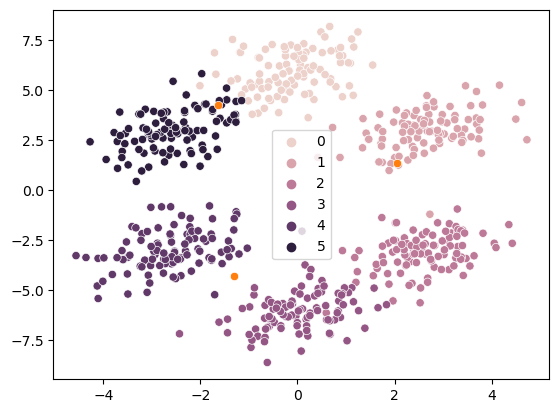

In [47]:
koh.plot_clusters(labels=hexagon['c'])

Używanie liczby K mniejszej niż liczba klas jest bez sensu, gdyż nie mamy szans wykrycia wszystkich klastrów. V-measure wynosi 0.67

In [43]:
# K = C

In [48]:
koh = KOH(2, (3, 2))

In [51]:
koh.train(hex_train, lambda_max=10)

In [52]:
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))

clusters: 6
v measure: 0.9318675623342372


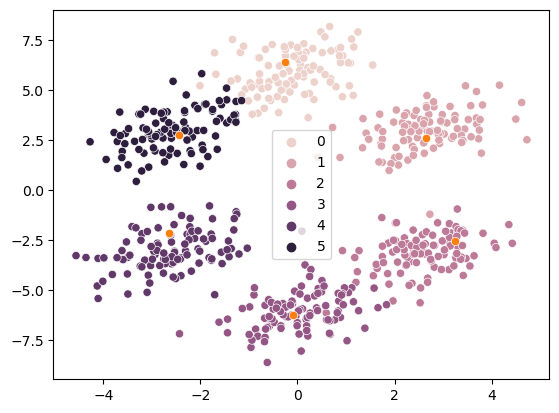

In [53]:
koh.plot_clusters(labels=hexagon['c'])

Użycie K = C ma największy sens, gdyż wtedy każdy neuron odpowiada jednemu klastrowi

In [54]:
# K > C

In [55]:
koh = KOH(2, (30, 20))

In [56]:
koh.train(hex_train, lambda_max=10)

In [57]:
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))

clusters: 6
v measure: 0.9410335358882488


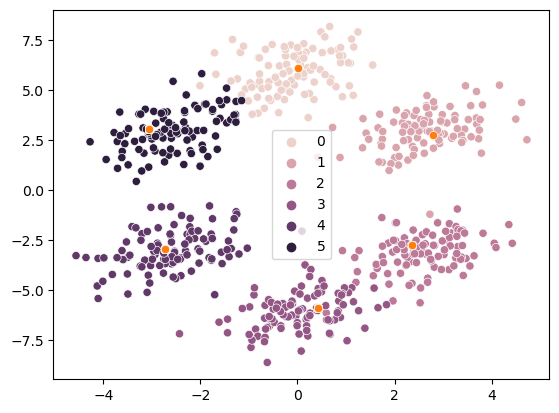

In [58]:
koh.plot_clusters(labels=hexagon['c'])

Widzimy że przy użyciu bardzo gęstej siatki dostajemy świetne wyniki. Już przy 10 iteracjach punkty siatki zbiegają do 6 konkretnych punktów. Normalnie nie znamy prawdziwej ilości klastrów, dlatego warto stosować o wiele gęstszą siatkę.

### Cube dataset

In [101]:
koh = KOH(3, (30, 20))

In [102]:
koh.train(cube_train, lambda_max=10)

In [103]:
preds = koh.predict(cube_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(cube['c'].to_numpy(), preds))

clusters: 4
v measure: 0.7570114489418747


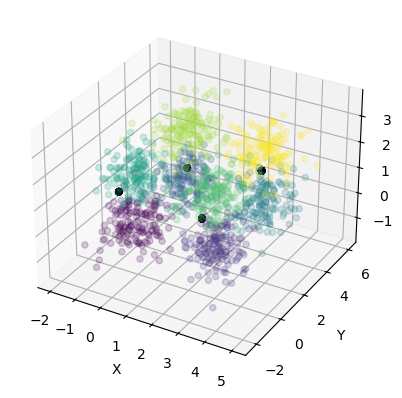

In [104]:
koh.plot_clusters(labels=cube['c'], type='cube')

W pewnym sensie dobrze wykrywa, bo można ten zbiór podzielić na 4 klastry. Istnieje jednak lepszy, na 8. Możemy spróbować użyć parametru wygaszania w funkcji sąsiedztwa i zwiększyć liczbę epok. Możemy także zmniejszyć nieco zagęszczenie siatki, gdyż nie jest nam potrzebne aż 600 neuronów.

In [128]:
koh = KOH(3, (8, 6))

In [129]:
koh.train(cube_train, lambda_max=100, use_nhood_decay=True)

In [130]:
preds = koh.predict(cube_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(cube['c'].to_numpy(), preds))

clusters: 6
v measure: 0.7954358054062408


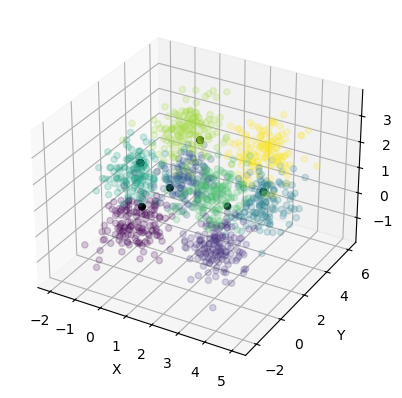

In [131]:
koh.plot_clusters(labels=cube['c'], type='cube')

Lepiej, ale nadal mamy za mało klastrów. Spróbujmy zawęzić nieco oddziaływanie funkcji przyciągania i ustawić parametr r na większy od 1.

clusters: 7
v measure: 0.8668764259975958


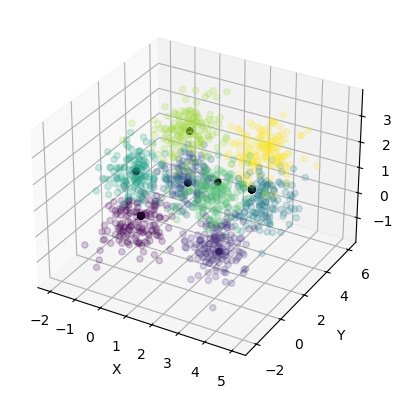

In [133]:
koh = KOH(3, (8, 6))
koh.train(cube_train, lambda_max=100, r=1.2, use_nhood_decay=True)
preds = koh.predict(cube_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(cube['c'].to_numpy(), preds))
koh.plot_clusters(labels=cube['c'], type='cube')

Zdecydowanie lepiej, uzyskaliśmy v-score na poziomie 0.87, jednakże nadal nie jest to idealna klasteryzacja.